In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import genfromtxt
import pickle
from scipy.stats import norm
from scipy.ndimage import gaussian_filter1d
import pandas as pd

In [34]:
def gfun_55(x):
    """Performance function for reliability problem 55.

    Parameters
    ----------
        x : numpy.array of float(s)
            Values of independent variables: columns are the different parameters/random variables (x1, x2,...xn) and rows are different parameter/random variables sets for different calls.

    Returns
    -------
        g_val_sys : numpy.array of float(s)
            Performance function value for the system.
        g_val_comp : numpy.array of float(s)
            Performance function value for each component.
        msg : str
            Accompanying diagnostic message, e.g. warning.
    """
    import numpy as np
    # expected number of random variables/columns
    nrv_e = 2

    g, g1, g2, g3, g4 = float('nan'), float('nan'), float('nan'), float('nan'), float('nan')
    msg = 'Ok'
    x = np.array(x, dtype='f')

    n_dim = len(x.shape)
    if n_dim == 1:
        x = np.array(x)[np.newaxis]
    elif n_dim > 2:
        msg = 'Only available for 1D and 2D arrays.'
        return float('nan'), float('nan'), msg

    nrv_p = x.shape[1]
    if nrv_p != nrv_e:
        msg = f'The number of random variables (x, columns) is expected to be {nrv_e} but {nrv_p} is provided!'
    else:
        g1 = 0.5 + 7.0 * (x[:, 0] - x[:, 1]) ** 4 + (x[:, 0] - x[:, 1]) / np.sqrt(2)
        g2 = 0.5 + 7.0 * (x[:, 0] - x[:, 1]) ** 4 - (x[:, 0] - x[:, 1]) / np.sqrt(2)
        g3 = (x[:, 0]**2 - x[:, 1]) + 5 / np.sqrt(2) - 2.0
        g4 = (x[:, 1] - x[:, 0]**2) + 5 / np.sqrt(2) - 2.0
        g = np.amin(np.stack((g1, g2, g3, g4)), 0)

    g_val_sys = g
    g_val_comp = np.stack((g1, g2, g3, g4))
    return g_val_sys, g_val_comp, msg

In [35]:
dim = 2
n_mcs = int(1e6)
Xtest = np.random.uniform(-1.0, 1.0, size=(n_mcs, dim))
y_test = gfun_55(Xtest)

Pf_ref = np.sum( y_test[0] < 0 ) / n_mcs
B_ref= - norm.ppf( Pf_ref )
Pf_ref, B_ref

(0.029509, 1.888059225221381)

In [36]:
samples = int(1e3)
X_fix = np.ones(samples)*0
X_var = np.linspace(-1, 1,samples)
X_fix1 = np.stack((X_fix, X_var), axis=1)
X_fix2 = np.stack((X_var, X_fix), axis=1)

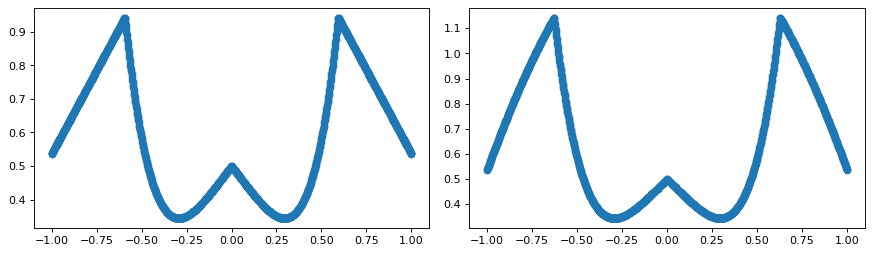

In [37]:
y_fix1 = gfun_55(X_fix1)
y_fix2 = gfun_55(X_fix2)

cm = 2 /2.54  # centimeters in inches
# plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams["font.size"] = 12

fig1, axs = plt.subplots(1,2, figsize=(15*cm, 5*cm), sharex = 'col', dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(left=0.1, right=0.98, top=0.92, bottom=0.22, hspace = 0.3, wspace=0.1)

axs[0].scatter(X_var, y_fix1[0])
axs[1].scatter(X_var, y_fix2[0])

In [ ]:
# Loading final pf results for all experiments

number_experiments = 5
initial_doe = 10
active_points = 40

PF_evol = np.zeros ((active_points, number_experiments))

for Batch in range (0, number_experiments):
    
    file_name = 'VS_Batch_' + str(Batch+1) +'.sav'

    experiment = pickle.load(open(file_name, 'rb'))
    
    for points in range (0, active_points):
        
        training_points = initial_doe + points+1

        PF_evol[points, Batch] = experiment['BNN_'+ str(training_points)][1]

In [ ]:
Pf_evol.shape

In [ ]:
cm = 2 /2.54  # centimeters in inches
# plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams["font.size"] = 12

fig3, axs = plt.subplots(2,1, figsize=(17*cm, 10*cm), sharex = 'col', dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(left=0.1, right=0.98, top=0.92, bottom=0.22, hspace = 0.3, wspace=0.1)

training_points = [i for i in range(10, 50)]

#------------------------------------ in case a limit state has any pf = 0 
penalization = 10e-7
ls_penal = 1

Pf_corr = pd.DataFrame(PF_evol)      #check colum with values to penalize
Pf_corr.replace([0], (penalization), inplace=True)
B_evol_CORR = - norm.ppf(Pf_corr)

axs[0].axhline(y = Pf_ref, color = '#e31a1c', linestyle = ':', lw=2.0)
axs[0].set_title('PF1', fontsize = 15)

axs[1].axhline(y = B_ref, color = '#e31a1c', linestyle = ':', lw=2.0)
axs[1].set_title('B1', fontsize = 15)

#PF EVOLUTION -------------------------------------------------
# for points in range(active_points):
sigma_std = 1.5

mean_pf1 = np.median(PF_evol , axis=1)
std_pf1 = np.std(PF_evol, axis=1)
CI_pf1 = 1.96 * (std_pf1 / np.sqrt(number_experiments)) 
axs[0].plot(training_points, gaussian_filter1d(mean_pf1, sigma=sigma_std))
axs[0].fill_between(training_points, gaussian_filter1d(mean_pf1 + CI_pf1, sigma=sigma_std), gaussian_filter1d(mean_pf1 - CI_pf1, sigma=sigma_std), alpha=0.1)

mean_b1 = np.median(B_evol_CORR , axis=1)
std_b1 = np.std(B_evol_CORR, axis=1)
CI_b1 = 1.96 * (std_b1 / np.sqrt(number_experiments)) 
axs[1].plot(training_points, gaussian_filter1d(mean_b1, sigma=sigma_std))
axs[1].fill_between(training_points, gaussian_filter1d(mean_b1 + CI_b1, sigma=sigma_std), gaussian_filter1d(mean_b1 - CI_b1, sigma=sigma_std), alpha=0.1)